# Problem Statement

The large company who is into beverages business in Australia. They sell their products through various super-markets and also engage into heavy promotions throughout the year. Their demand is also influenced by various factors like holiday, seasonality. They needed forecast of each of products at item level every week in weekly buckets.

# Objective

1. Build at least 4-5 multivariable forecasting model which included ML or Deep Learning based Model in PySpark leveraging parallel computing techniques.

2. Demonstrate best in class forecast accuracy (Forecast Accuracy = 1 - Wt. MAPE where Wt. MAPE = sum(Error)/sum(Actual).

3. Write a code in such a way you run the model in least time.

4. Demonstrate explainability in the form of contribution of each variables

5. Leveage Feature Engineering concepts to derive more variables to gain accuracy improvement


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/papitaAlgodonCplusplus/LISUM24/main/Week%207/Datatset/forecasting_case_study.csv')

# Dataset Raw Visualization

In [71]:
df

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.00,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.00,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.00,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.00,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1213,SKU6,10/18/2020,96619,54%,0,1,0,-7.56,1,0,0,0
1214,SKU6,10/25/2020,115798,52%,0,1,0,-8.39,1,0,0,0
1215,SKU6,11/1/2020,152186,54%,1,0,1,-7.43,1,0,0,0
1216,SKU6,11/8/2020,26445,44%,1,0,1,-5.95,1,0,0,0


# Features


* **Product:** X Product that the company offers to their clients

* **Date:** *Month - Day - Year* where row X transactions ocurred

* **Sales:** Number of products X sold that day

* **Price Discount (%):** Discount applied to the product X that day

* **In-Store Promo:** Wheter there was promotion of that product indoors or not

* **Catalogue Promo:** Wheter there was promotion of that product in the catalogue or not

* **Store End Promo:** Wheter there was promotion of that product outdoors or not

* **Google_Mobility:** Google Mobility, also known as Google COVID-19 Community Mobility Reports, is a data initiative launched by Google to provide insights into how people's movements and activities have changed in response to the COVID-19 pandemic, this as a feature column with ranges [-inf, inf] means wheter X product sales during Y date were supossed to change or not, and by how much.

* **Covid_Flag:** A binary column that only activates when google mobility predicts changes on sales of X product during Y date.

* **V_DAY:** Wheter that day was Valentine's day for the company or not

* **Easter:** Wheter that day was Easter for the company or not

* **Christmas:** Wheter that day was Christmas for the company or not

# Data types

**Categorical Data:**
- Product: X Product that the company offers to their clients

**Continuous Numerical Data:**
- Date: Month - Day - Year where row X transactions occurred (If changed to another analogous format)
- Sales: Number of products X sold that day
- Price Discount (%): Discount applied to product X that day
- Google_Mobility: Google Mobility index indicating the change in sales due to the COVID-19 pandemic (ranges [-inf, inf])

**Binary Data:**
- In-Store Promo: Whether there was an indoor promotion of that product or not
- Catalogue Promo: Whether there was a promotion of that product in the catalogue or not
- Store End Promo: Whether there was an outdoor promotion of that product or not
- Covid_Flag: A binary column that activates when Google Mobility predicts changes in sales of X product during Y date
- V_DAY: Whether that day was Valentine's day for the company or not
- Easter: Whether that day was Easter for the company or not
- Christmas: Whether that day was Christmas for the company or not

# Data preprocessing

## NA values

<font color= 'purple'>**Approach:**</font> First let's see if there are any NA values to handle, if so, either mean or mode could be applied.

In [72]:
na_counts = df.isna().sum()

for column, na_count in na_counts.items():
    print(f"{column}: {na_count}")

Product: 0
date: 0
Sales: 0
Price Discount (%): 0
In-Store Promo: 0
Catalogue Promo: 0
Store End Promo: 0
Google_Mobility: 0
Covid_Flag: 0
V_DAY: 0
EASTER: 0
CHRISTMAS: 0


## Outliers

In [73]:
def plot_data(df, column, sort=False, x=None):
  if sort:
    sorted_df = df.sort_values(by=column)
    plt.plot(sorted_df[column], sorted_df[x])
    plt.title('Sorted: '+ column + ' by ' + x)
    plt.xlabel(x)
    plt.ylabel(column)
    plt.show()

  else:
    # Plotting numerical column
    plt.figure(figsize=(10, 6))
    if x != None:
      plt.scatter(df[column], df[x])
      plt.xlabel(column)
      plt.ylabel(x)
      plt.title('Scatter Plot')
      plt.show()
    else:
      plt.plot(df[column])
      plt.title(column)
      plt.show()

def delete_noise(df, column, reduction_method='IQR', error_margin=1.5, plot_noise=True, threshold=4, renew=True):
  if reduction_method == 'IQR':
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - error_margin * IQR
    upper_bound = Q3 + error_margin * IQR

    noisy_indices = (df[column] < lower_bound) | (df[column] > upper_bound)

    if plot_noise:
      df['Is_Noisy'] = noisy_indices

      plt.figure(figsize=(10, 6))
      plt.scatter(df.index, df[column], c=df['Is_Noisy'], cmap='coolwarm', marker='o')
      plt.title('Identified Outliers')
      plt.colorbar(label='Outlier (1) / Non-outlier (0)')
      plt.show()

      df.drop('Is_Noisy', axis=1, inplace=True)

    if renew:
      return df.drop(df.index[noisy_indices]).copy()

  if reduction_method == 'Statistical':
    mean = df[column].mean()
    std_dev = df[column].std()

    noise_threshold = mean + threshold * std_dev
    noisy_indices = (df[column] - mean).abs() > threshold * std_dev

    if plot_noise:
      df['Is_Noisy'] = noisy_indices

      plt.figure(figsize=(10, 6))
      plt.scatter(df.index, df[column], c=df['Is_Noisy'], cmap='coolwarm', marker='o')
      plt.title('Identified Outliers')
      plt.colorbar(label='Outlier (1) / Non-outlier (0)')
      plt.show()

      df.drop('Is_Noisy', axis=1, inplace=True)

    if renew:
      return df[df[column] <= noise_threshold]

### Google Mobility

#### Stadistical Method

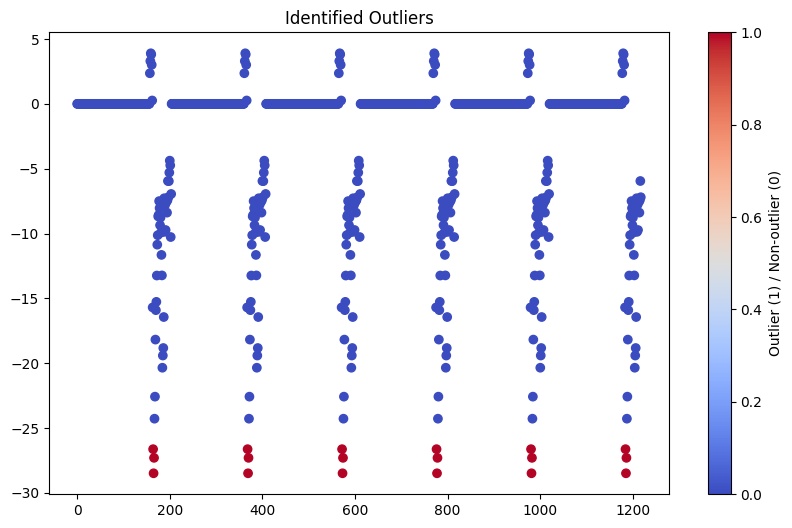

In [74]:
test_df = delete_noise(df, 'Google_Mobility', reduction_method='Statistical')

#### IQR Method

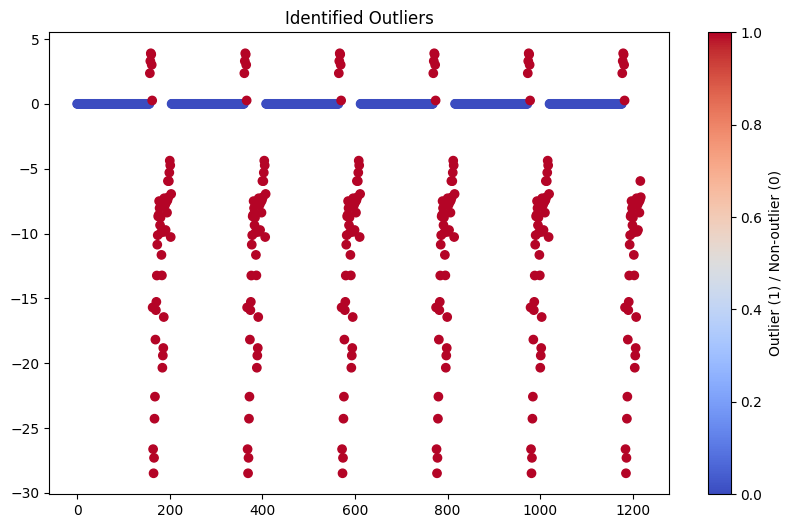

In [75]:
test_df = delete_noise(df, 'Google_Mobility')

#### Am I deleting outliners?

<font color='red'>**Discarded:**</font> Because the outliers are actually a pattern and is not greater than 30% decrease prediction (which is lucid in the context of COVID)

### Discount

#### Stadistical Method

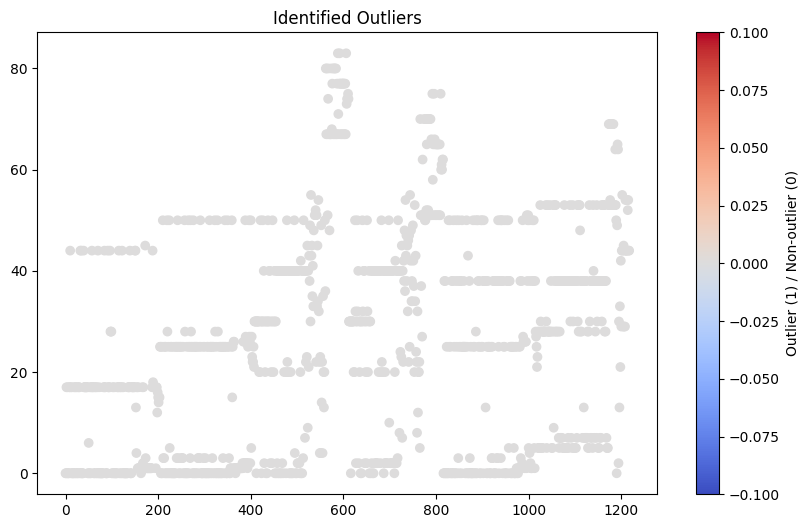

In [76]:
df['Price Discount (%)'] = df['Price Discount (%)'].str.replace('%', '').astype(float)
test_df = delete_noise(df, 'Price Discount (%)', reduction_method='Statistical')

#### IQR Method

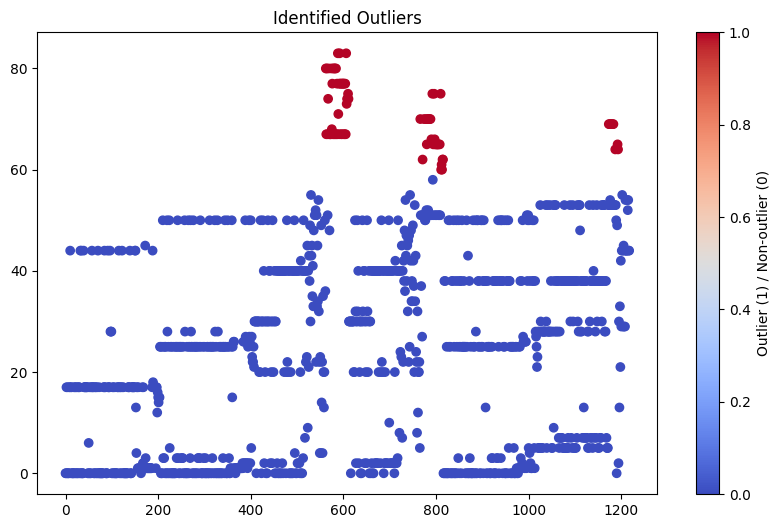

In [77]:
test_df = delete_noise(df, 'Price Discount (%)', error_margin=0.5)

#### Am I deleting outliners?

<font color='red'>**Discarded:**</font> Because the outliers % of discount are  common in the context of this company's timeline given some season and acceptation would only generate weights misplacement later on model training and tuning.

With this, outlier detection is concluded, as there is no binary noise to delete statistically and 'Sales' is the label/target, not a feature.

## Skewed Data

### Google Mobility Normalization

<font color='green'>**Accepted:**</font> Normalization helps to ensure faster convergence and prevents biased magnitude domination during training.

<font color= 'purple'>**Approach:**</font> First step is to create a function to fastly plot the resulting values of the normalized columns, then, normalization is applied.

In [78]:
import plotly.graph_objects as go

def plot(df, column):
  fig = go.Figure()

  fig.add_trace(go.Scatter(y=df[column], mode='lines+markers', name=column))

  # Customize the layout
  fig.update_layout(
      xaxis_title="Index",
      yaxis_title=column,
  )

  # Show the Plotly figure
  fig.show()

plot(df, 'Google_Mobility')

In [79]:
min = df['Google_Mobility'].min()
max = df['Google_Mobility'].max()

df['Google_Mobility'] = (df['Google_Mobility'] - min) / (max - min)

plot(df, 'Google_Mobility')

### Google_Mobility logarithmic transformation

In [80]:
test_df['Google_Mobility'] = np.log1p(df['Google_Mobility'])
plot(test_df, 'Google_Mobility')

<font color='red'>**Discarded:**</font> Logarithmic transformation has no effect on this column (neither price discount) because the trend stays still to the end.

### Price Discount (%) Normalization

In [81]:
plot(df, 'Price Discount (%)')

In [82]:
min = df['Price Discount (%)'].min()
max = df['Price Discount (%)'].max()

df['Price Discount (%)'] = (df['Price Discount (%)'] - min) / (max - min)

plot(df, 'Price Discount (%)')

## Date Encoding

<font color='green'>**Accepted:**</font> Encoding 'date' column is necessary so the chosen model can make forecast predictions over seasonality patterns.

<font color= 'purple'>**Approach:**</font> Using the datetime option from pandas, is easy to extract year, month and day for each row into new columns

In [83]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

## Aggregation for Time Analysis

<font color='green'>**Accepted:**</font> Aggregating the whole dataframe to obtain 2 new datasets based on year and month could be beneficial both for EDA and Training.

<font color= 'purple'>**Approach:**</font> First step is grouping the dataframe by month or year, apply aggregation based on 4 columns selected to EDA:

1. Sales by it's total sum over the month/year
2. Discount as the standard deviation it had during the month/year
3. Google Mobility by it's mean value during the month/year
4. Product by creating 6 different aggregated dataframes

### By month

In [116]:
df_sku1 = df[df['Product'] == 'SKU1']
df_sku2 = df[df['Product'] == 'SKU2']
df_sku3 = df[df['Product'] == 'SKU3']
df_sku4 = df[df['Product'] == 'SKU4']
df_sku5 = df[df['Product'] == 'SKU5']
df_sku6 = df[df['Product'] == 'SKU6']

def aggregate(df, target):
  local_df = df.groupby(df['date'].dt.to_period(target)).agg({
      'Sales': 'sum',
      'Price Discount (%)': 'std',
      'Google_Mobility': 'mean',
      'Product': 'count'
  }).reset_index()
  return local_df

monthly_aggregated_sku1 = aggregate(df_sku1, 'M')
monthly_aggregated_sku2 = aggregate(df_sku2, 'M')
monthly_aggregated_sku3 = aggregate(df_sku3, 'M')
monthly_aggregated_sku4 = aggregate(df_sku4, 'M')
monthly_aggregated_sku5 = aggregate(df_sku5, 'M')
monthly_aggregated_sku6 = aggregate(df_sku6, 'M')
plot(monthly_aggregated_sku3, 'Sales')

### By year

In [118]:
yearly_aggregated_sku1 = aggregate(df_sku1, 'Y')
yearly_aggregated_sku2 = aggregate(df_sku2, 'Y')
yearly_aggregated_sku3 = aggregate(df_sku3, 'Y')
yearly_aggregated_sku4 = aggregate(df_sku4, 'Y')
yearly_aggregated_sku5 = aggregate(df_sku5, 'Y')
yearly_aggregated_sku6 = aggregate(df_sku6, 'Y')

plot(yearly_aggregated_sku6, 'Product')

This concludes data preprocessing, now all the data is normalized and has no issues to resolve before entering training stage.

# EDA & Feature Analysis

## Feature Engineering

### Lag Period Difference (A.K.A Derivative Function)

This will return a column with the difference or change ratio of the sales values based on the previous sale.

#### Global Dataframe

In [134]:
import plotly.express as px

df_sorted_date = df.sort_values(by='date')
df_sorted_date = df_sorted_date.reset_index(drop=True)

shifted_sales = df_sorted_date['Sales'].shift(1)
df_sorted_date['Change_Ratio'] = df_sorted_date['Sales'] - shifted_sales

fig = px.line(df_sorted_date, x=df_sorted_date.index, y=['Sales', 'Change_Ratio'],
              labels={'x': 'Date', 'y': 'Sales'},
              title='Sales and Change Ratio')

fig.show()

#### Monthly Dataframe

In [173]:
monthly_dfs = [monthly_aggregated_sku1, monthly_aggregated_sku2, monthly_aggregated_sku3, monthly_aggregated_sku4,
               monthly_aggregated_sku5, monthly_aggregated_sku6]

for idx, df in enumerate(monthly_dfs):
    shifted_sales = df['Sales'].shift(1)
    df['Change_Ratio'] = df['Sales'] - shifted_sales
    monthly_dfs[idx] = df

combined_df = pd.concat([df['Change_Ratio'] for df in monthly_dfs], axis=1)
combined_df.columns = [f"SKU{idx+1}" for idx in range(len(monthly_dfs))]
combined_df.dropna(inplace=True)

fig = px.line(combined_df, x=combined_df.index, y=combined_df.columns, title='Change Ratio for SKUs')
fig.show()

#### Yearly Dataframe

In [174]:
yearly_dfs = [yearly_aggregated_sku1, yearly_aggregated_sku2, yearly_aggregated_sku3,
              yearly_aggregated_sku4, yearly_aggregated_sku5, yearly_aggregated_sku6]

for idx, df in enumerate(yearly_dfs):
    shifted_sales = df['Sales'].shift(1)
    df['Change_Ratio'] = df['Sales'] - shifted_sales
    yearly_dfs[idx] = df

combined_df = pd.concat([df['Change_Ratio'] for df in yearly_dfs], axis=1)
combined_df.columns = [f"SKU{idx+1}" for idx in range(len(yearly_dfs))]
combined_df.dropna(inplace=True)

fig = px.line(combined_df, x=combined_df.index, y=combined_df.columns, title='Change Ratio for SKUs (Yearly)')
fig.show()

## Sales by Date and Product

In [110]:
unique_products = df['Product'].unique()

fig = go.Figure()

for product in unique_products:
    product_data = df[df['Product'] == product]
    fig.add_trace(go.Scatter(
        x=product_data['date'],
        y=product_data['Sales'],
        mode='lines+markers',
        name=product
    ))

fig.update_layout(
    title="Sales Over Time by Product",
    xaxis_title="Date",
    yaxis_title="Sales",
    xaxis=dict(type='date')
)

fig.show()

## Product Count

In [111]:
import plotly.express as px

fig = px.bar(df, x='Product', color='Product', title='Product Sales')

fig.show()

## Product Sales

In [112]:
fig = px.bar(df, x='Product', y='Sales', color='Product', title='Product Sales')

fig.show()